---
date: "2025-05-30"
author: "Diego Scarabelli"
title: "Is the US Fiscal Deficit Correlated to Price Inflation?"
description: "In other words: when there is a fiscal deficit, is there price inflation, possibly with a time lag? If the deficit increases or decreases, does inflation follow?"
tags:
- jupyter
- economics
- time-series
---

<!--more-->

In other words: when there is a fiscal deficit, is there price inflation, possibly with a time lag? If the deficit increases or decreases, does inflation follow?

This question arose from a discussion about an excerpt from [The Deficit Myth](https://stephaniekelton.com/book/), which explores macroeconomic topics such as fiscal and monetary policy, focusing on countries where the government is the monopoly issuer of its currency and most debt is denominated in that currency.

To answer this question, I used data directly from the Federal Reserve Bank's [FRED](https://fred.stlouisfed.org/) datasets. To avoid bias, I did not consult other analyses before conducting my own. My goal was to approach the problem with simple, logical, and statistically sound steps, aiming for a clear answer to a straightforward question.

Below are my findings. For a detailed explanation of the process and reasoning behind each step, keep reading.

## Findings

1. The available data on the US fiscal deficit and price inflation is limited. The fiscal deficit as a proportion of GDP (`FYFSGDA188S`) is only meaningful at an annual frequency, while the personal consumption expenditures index (`PCEPILFE`), though available quarterly, starts only in 1959 and must be downsampled to annual frequency for comparison. This scarcity of overlapping, low-frequency data restricts statistical significance and limits the potential for robust insights.
2. Cross-correlating the annual fiscal deficit (`FYFSGDA188S`) with annual price inflation (annual change in the `PCEPILFE` index) reveals no statistically significant correlation at any time lag.
3. This result is further validated after differencing both time series to remove unit roots, as confirmed by the Augmented Dickey-Fuller test. Although the KPSS stationarity test indicates some remaining heteroscedasticity, this is unlikely to materially affect the outcome.

💡 **Key Takeaway**

The available data does not provide statistically significant evidence of cross-correlation between the US fiscal deficit and price inflation, either for the level series or for their rates of change.

## Data Analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 3

# Standard library imports
from dataclasses import dataclass, field
from typing import Dict, List, Optional

# Third-party imports
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
from statsmodels.tsa.stattools import adfuller, kpss

# Plotly configuration.
# Set the default renderer to a static format for GitHub. Comment out if you want to use interactive plots.
pio.renderers.default = "svg"  # or "png", "jpeg", "pdf"
# # Set the default theme to plotly_dark for the entire session
# pio.templates.default = "plotly_dark"

### Data Ingestion

The FRED datasets are extensive and offer multiple ways to measure both fiscal deficit and inflation.  

For the fiscal deficit, I considered [FYFSD](https://fred.stlouisfed.org/series/FYFSD) (federal surplus or deficit, absolute value) and [FYFSGDA188S](https://fred.stlouisfed.org/series/FYFSGDA188S) (federal surplus or deficit as a percent of gross domestic product). For this analysis, the deficit as a proportion of GDP is more meaningful, as it normalizes the deficit relative to the size of the economy, which changes over time.

Inflation is also measured in several ways. The Consumer Price Index (CPI) comes in variants such as [all items](https://fred.stlouisfed.org/series/CPIAUCSL), [sticky price](https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL), and [less food and energy](https://fred.stlouisfed.org/series/CPILFESL). However, the Federal Reserve’s preferred measure is the Personal Consumption Expenditures (PCE) Price Index, which also has several forms: [fixed-base PCE](https://fred.stlouisfed.org/series/PCE), [chain-type PCE](https://fred.stlouisfed.org/series/PCEPI), and [less food and energy](https://fred.stlouisfed.org/series/PCEPILFE). For this analysis, I selected the chain-type PCE price index excluding food and energy ([PCEPILFE](https://fred.stlouisfed.org/series/PCEPILFE)), as it is widely used in macroeconomic research and forecasting.

In [2]:
# 1. Define a dataclass to hold metric information and its DataFrame
@dataclass
class FredMetric:
    name: str  # Changed from id
    description: str
    units: str  # Changed from unit
    frequency: str  # Added
    data: Optional[pd.DataFrame] = field(default=None, repr=False) # repr=False to avoid printing full DF

# Configuration for the FRED metrics to download
metrics_config = [
    {"name": "FYFSGDA188S", "description": "Federal surplus or deficit (-)", "units": "percent_gdp", "frequency": "annually"},
    {"name": "PCEPILFE", "description": "Personal consumption expenditures excluding food and energy (chain-type price index).", "units": "index", "frequency": "quarterly"},
    {"name": "ECIWAG", "description": "Employment cost index, wages and salaries, private industry workers", "units": "index", "frequency": "quarterly"},
]

# Dictionary to collect FredMetric instances with data
metrics_container = {}

# 2. Download the csv file from the FRED website for each metric
# 3. Add the dataframe containing the data to the FredMetric instance
for metric_cfg in metrics_config:
    metric_name = metric_cfg["name"]
    metric_units = metric_cfg["units"]
    metric_frequency = metric_cfg["frequency"]
    
    fred_url = f"https://fred.stlouisfed.org/series/{metric_name}/downloaddata/{metric_name}.csv"
    
    print(f"Downloading data for {metric_name} from {fred_url}...")
    df_metric_data = pd.read_csv(fred_url, parse_dates=["DATE"])
    
    # Rename columns
    df_metric_data = df_metric_data.rename(columns={"DATE": "timestamp", "VALUE": "value"})
    
    # Add name and units
    df_metric_data["name"] = metric_name
    df_metric_data["units"] = metric_units
    
    # Ensure "value" is numeric
    df_metric_data["value"] = pd.to_numeric(df_metric_data["value"], errors="coerce")
    df_metric_data = df_metric_data.dropna(subset=["value"])
    
    # Select and order columns
    df_metric_data = df_metric_data[["timestamp", "name", "value", "units"]]
    
    # Create FredMetric instance with data
    metric_instance = FredMetric(
        name=metric_name,
        description=metric_cfg["description"],
        units=metric_units,
        frequency=metric_frequency,
        data=df_metric_data
    )
    
    # Create dictionary key and add instance to dictionary
    dict_key = f"{metric_name}_{metric_frequency}_{metric_units}"
    metrics_container[dict_key] = metric_instance
    
    print(f"Successfully processed {metric_name}. Shape: {df_metric_data.shape}")

# 4. Print the keys of the metrics_container dictionary
print("Metrics container keys:")
for key in metrics_container.keys():
    print(key)

Successfully processed FYFSGDA188S. Shape: (96, 4)
Successfully processed PCEPILFE. Shape: (796, 4)
Successfully processed ECIWAG. Shape: (97, 4)
Metrics container keys:
FYFSGDA188S_annually_percent_gdp
PCEPILFE_quarterly_index
ECIWAG_quarterly_index


### Visual Inspection
Alright, we've successfully grabbed our data from FRED. Before we dive into any heavy-duty analysis, let's quickly plot these time series. This will give us a first look at what we're dealing with and help us spot any obvious patterns or quirks in the raw data.

In [3]:
def plot_dual_axis_series(metrics_container: Dict[str, FredMetric], y1_keys: List[str], y2_keys: List[str]):
    """
    Plot multiple time series on a dual y-axis plot using Plotly.
    
    :param metrics_container: Dictionary containing FredMetric instances with data
    :param y1_keys: Keys of metrics_container corresponding to metrics to plot on y1 (left axis)
    :param y2_keys: Keys of metrics_container corresponding to metrics to plot on y2 (right axis)
    """

    fig = go.Figure()

    # Plot series on y1 axis
    for key in y1_keys:
        data = metrics_container[key].data
        fig.add_trace(go.Scatter(
            x=data["timestamp"],
            y=data["value"],
            mode="lines+markers",
            name=key,
            yaxis="y1"
        ))

    # Plot series on y2 axis
    for key in y2_keys:
        data = metrics_container[key].data
        fig.add_trace(go.Scatter(
            x=data["timestamp"],
            y=data["value"],
            mode="lines+markers",
            name=key,
            yaxis="y2"
        ))

    # Use the first key in each group for axis labels
    y1_label = metrics_container[y1_keys[0]].units if y1_keys else ""
    y2_label = metrics_container[y2_keys[0]].units if y2_keys else ""

    fig.update_layout(
        width=1200,
        height=600,
        xaxis=dict(
            title="Date",
            minor=dict(ticks="outside"),
            dtick="M120",
            tickformat="%Y"
        ),
        yaxis=dict(
            title=y1_label,
            side="left"
        ),
        yaxis2=dict(
            title=y2_label,
            overlaying="y",
            side="right",
            showgrid=False
        ),
        legend=dict(x=0.00, y=1.16, bgcolor="rgba(255,255,255,0.5)")
    )
    fig.show()

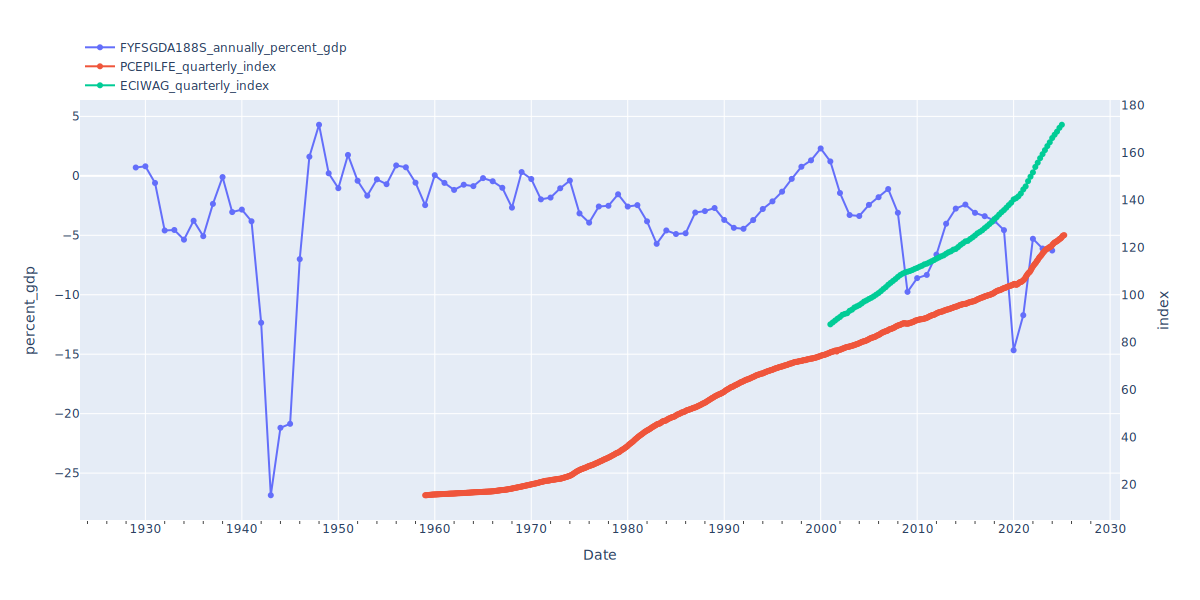

In [4]:
plot_dual_axis_series(metrics_container,
                      y1_keys=["FYFSGDA188S_annually_percent_gdp"],
                      y2_keys=["PCEPILFE_quarterly_index", "ECIWAG_quarterly_index"])

The time series relevant to our analysis, `FYFSGDA188S` (fiscal deficit) and `PCEPILFE` (price inflation index), cover different time ranges and have unmatched frequencies. Due to the limited availability of `PCEPILFE` data, our analysis focuses on the period from 1959 to the present. To enable cross-correlation analysis, we must also downsample the `PCEPILFE` data to an annual frequency to match that of `FYFSGDA188S`.

It's also insightful to include the `ECIWAG` (wage inflation index) series in the graph above. Over the last 20 years, the period for which `ECIWAG` data is available, wage inflation has closely tracked price inflation. This suggests that, during this period, price inflation may not have significantly eroded purchasing power, as wage growth has largely kept pace.

### Resample Index Series to Annual Frequency

Resample PCEPILFE and ECIWAG from quarterly to annual using the same fiscal year-end timestamps as FYFSGDA188S.

In [5]:
# 1. Get fiscal deficit timestamps
deficit_key = "FYFSGDA188S_annually_percent_gdp"
fiscal_timestamps = metrics_container[deficit_key].data["timestamp"].sort_values().reset_index(drop=True)

# 2. Keys to resample
to_resample = ["PCEPILFE_quarterly_index", "ECIWAG_quarterly_index"]

for key in to_resample:
    metric = metrics_container[key]
    df = metric.data.copy().sort_values("timestamp")
    
    # 3. Assign each row to a fiscal year period using FYFSGDA188S timestamps
    bins = [pd.Timestamp.min] + list(fiscal_timestamps)
    labels = fiscal_timestamps
    df["fiscal_year"] = pd.cut(
        df["timestamp"],
        bins=bins,
        labels=labels,
        right=True,
        include_lowest=True
    )
    df = df.dropna(subset=["fiscal_year"])
    
    # 4. Group by fiscal year and aggregate (mean)
    resampled = df.groupby("fiscal_year", observed=True).agg(value=("value", "mean")).reset_index()
    resampled = resampled.rename(columns={"fiscal_year": "timestamp"})
    resampled["timestamp"] = pd.to_datetime(resampled["timestamp"])
    resampled["name"] = metric.name
    resampled["units"] = metric.units
    resampled = resampled[["timestamp", "name", "value", "units"]]
    resampled = resampled.dropna(subset=["value"])
    
    # 5. Create new FredMetric instance
    new_key = f"{metric.name}_annually_{metric.units}"
    metrics_container[new_key] = FredMetric(
        name=metric.name,
        description=metric.description + " (Annually Resampled)",
        units=metric.units,
        frequency="annually",
        data=resampled
    )
    print(f"Added {new_key} to metrics_container. Shape: {resampled.shape}")

# 6. Print the keys of the metrics_container dictionary
print("Metrics container keys:")
for key in metrics_container.keys():
    print(key)

Added PCEPILFE_annually_index to metrics_container. Shape: (66, 4)
Added ECIWAG_annually_index to metrics_container. Shape: (24, 4)
Metrics container keys:
FYFSGDA188S_annually_percent_gdp
PCEPILFE_quarterly_index
ECIWAG_quarterly_index
PCEPILFE_annually_index
ECIWAG_annually_index


As mentioned earlier, matching time series frequency is important. However, this process further reduces the number of data points available for analysis, already limited, down to just over sixty, constrained by the PCEPILFE series.  
This level of scarcity is concerning! Hopefully, we can still extract something statistically significant from the available data.

### Calculate Annual Percentage Change for Annually Resampled Index Metrics

To analyze inflation dynamics, the annually resampled index metrics are converted to annual percentage changes. This transformation not only matches standard inflation reporting practices but is also essential for removing mean trends, as further explained in the [Stationarity Testing](#stationarity-testing) section.

In [6]:
keys_for_pct_change = ["PCEPILFE_annually_index", "ECIWAG_annually_index"]

for key in keys_for_pct_change:

    original_metric = metrics_container[key]
    df_annual = original_metric.data.copy()

    # Calculate annual percentage change
    # Ensure data is sorted by timestamp before pct_change if not already guaranteed
    df_annual = df_annual.sort_values("timestamp")
    df_annual["value"] = df_annual["value"].pct_change() * 100
    
    # Update name and units for the new percentage change DataFrame
    df_annual["name"] = original_metric.name
    df_annual["units"] = "percent"
    
    # Drop the first row which will be NaN after pct_change
    df_annual_pct = df_annual.dropna(subset=["value"])

    # Create a new FredMetric instance for the percentage change series
    pct_metric_description = f"{original_metric.description} (Annual Percentage Change)"
    pct_metric_frequency = "annually"
    pct_metric_units = "percent"

    pct_metric_instance = FredMetric(
        name=original_metric.name,
        description=pct_metric_description,
        units=pct_metric_units,
        frequency=pct_metric_frequency,
        data=df_annual_pct
    )
    
    # Add the new metric to the metrics_container
    new_pct_key = f"{original_metric.name}_{pct_metric_frequency}_{pct_metric_units}"
    metrics_container[new_pct_key] = pct_metric_instance
    print(f"Added {new_pct_key} to metrics_container. Shape: {df_annual_pct.shape}")

# Print the keys of the metrics_container dictionary
print("Metrics container keys:")
for key in metrics_container.keys():
    print(key)

Added PCEPILFE_annually_percent to metrics_container. Shape: (65, 4)
Added ECIWAG_annually_percent to metrics_container. Shape: (23, 4)
Metrics container keys:
FYFSGDA188S_annually_percent_gdp
PCEPILFE_quarterly_index
ECIWAG_quarterly_index
PCEPILFE_annually_index
ECIWAG_annually_index
PCEPILFE_annually_percent
ECIWAG_annually_percent


We must truncate `FYFSGDA188S_annually_percent_gdp` to match the start date of `PCEPILFE_annually_percent`, since our objective is to cross-correlate the two series. We will not use `ECIWAG_annually_percent` for this analysis, but I find it useful to visualize alongside price inflation.

In [7]:
# Define keys for the metrics we want to cross-correlate
deficit_key = "FYFSGDA188S_annually_percent_gdp"
inflation_key = "PCEPILFE_annually_percent"

In [8]:
# Get the minimum timestamp in PCEPILFE_annually_percent
t_min = metrics_container[inflation_key].data["timestamp"].min()

# Truncate the FYFSGDA188S series to start at the same timestamp
df = metrics_container[deficit_key].data
truncated_df = df[df["timestamp"] >= t_min].copy()
metrics_container[deficit_key].data = truncated_df
print(f"Truncated {deficit_key} to start at {t_min}. New shape: {truncated_df.shape}")

Truncated FYFSGDA188S_annually_percent_gdp to start at 1960-01-01 00:00:00. New shape: (65, 4)


Let's plot the annually resampled and year-over-year change metrics alongside the fiscal deficit to visually compare their annual variations. This helps reveal any patterns or relationships between fiscal deficits, price inflation, and wage growth over time.

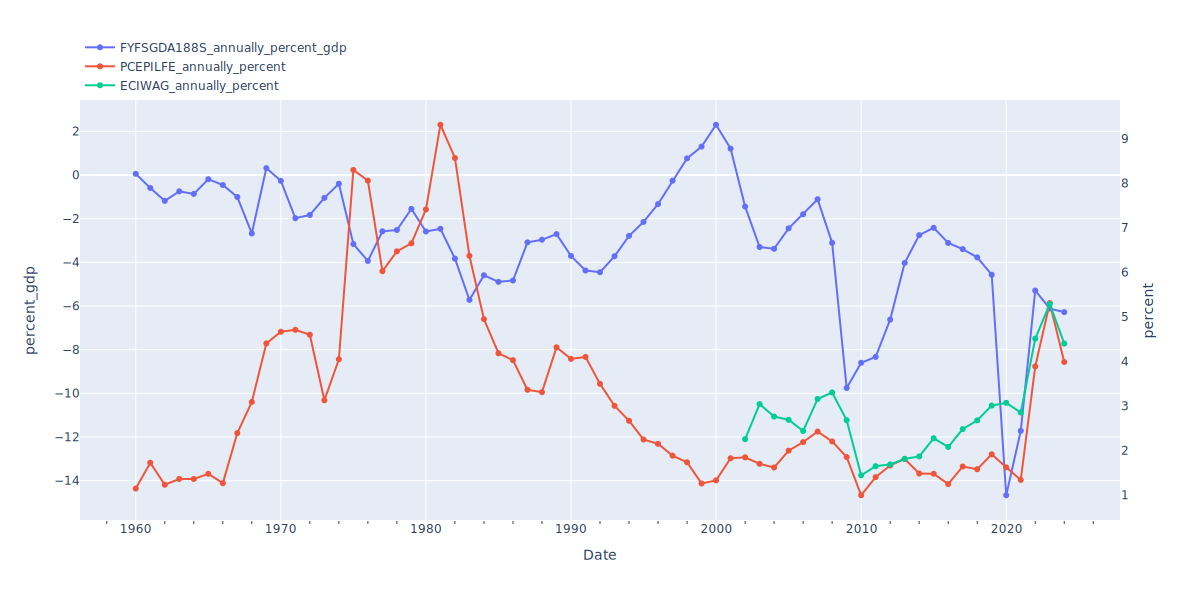

In [9]:
plot_dual_axis_series(
    metrics_container,
    y1_keys=[deficit_key],
    y2_keys=[inflation_key, "ECIWAG_annually_percent"]
)
    

### Cross-Correlation of Undifferenced (Level) Series

The [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) between two stochastic processes is defined as the ratio between their covariance (at a given lag) and the product of their standard deviations. In practical terms, this measures how much one time series tends to move in relation to another, as one is shifted forward or backward in time. By examining cross-correlation at different lags, we can explore whether changes in one series tend to precede, coincide with, or follow changes in the other. This is a foundational tool for investigating potential lead-lag relationships between economic variables such as fiscal deficits and inflation.


In [10]:

def calculate_and_plot_cross_correlation(
    metrics_container: dict, 
    key1: str, 
    key2: str, 
    max_lag: int = 10
) -> tuple:
    """
    Calculates and plots the Pearson product-moment correlation coefficients between two time series using the 
    variable-length segment (full overlap) method. The cross-correlation is the ratio between the covariance (at a given lag) and 
    the product of the two standard deviations. The series are assumed to be already aligned and have the same timestamps.
    
    Positive lag (lag > 0): Series 2 leads Series 1. A strong correlation at lag = +1 means changes in Series 2 tend to be followed 
    by similar changes in Series 1 one time period later.
    Negative lag (lag < 0): Series 1 leads Series 2.

    :param metrics_container: Dictionary containing FredMetric instances.
    :param key1: Key for the first series in metrics_container.
    :param key2: Key for the second series in metrics_container.
    :param max_lag: Maximum lag to consider for the range of lags.
    :returns: Tuple (lags, ccf_values) or (None, None) if an error occurs.
    """
    
    y1 = metrics_container[key1].data.value.values
    y2 = metrics_container[key2].data.value.values

    # Sanity checks
    if len(y1) != len(y2):
        print(f"Error: Series lengths do not match for {key1} and {key2}.")
        return None, None
    N = len(y1)
    if N < 2:
        print("Error: Less than 2 data points. Cannot calculate correlation.")
        return None, None
    if max_lag >= N:
        print(f"Warning: max_lag ({max_lag}) is >= N ({N}). This will result in NaNs for many lags due to no overlap.")
    elif N >= 2 and max_lag > N - 2:
        print(f"Warning: max_lag ({max_lag}) is > N-2 ({N-2}). Correlations at extreme lags might be NaN or based on very few points.")
    
    # Create lag array and initialize lists for CCF values and number of points used
    lags_array = np.arange(-max_lag, max_lag + 1)
    ccf_values = []
    n_points_used_for_lag = []

    # Calculate cross-correlation for each lag using variable segment length (full overlap) method
    for lag_val in lags_array:
        abs_lag = abs(lag_val)
        current_overlap_length = N - abs_lag
        n_points_used_for_lag.append(max(0, current_overlap_length))

        if current_overlap_length < 2:
            ccf_values.append(np.nan)
            continue

        if lag_val == 0:
            s1_segment = y1
            s2_segment = y2
        elif lag_val > 0:
            s1_segment = y1[lag_val:]
            s2_segment = y2[:-lag_val]
        else:
            s1_segment = y1[:current_overlap_length]
            s2_segment = y2[abs_lag:]
        
        if len(s1_segment) < 2 or len(s2_segment) < 2:
            ccf_values.append(np.nan)
        elif np.all(s1_segment == s1_segment[0]) or np.all(s2_segment == s2_segment[0]):
            ccf_values.append(np.nan)
        else:
            ccf_values.append(np.corrcoef(s1_segment, s2_segment)[0, 1])
            
    print(f"Cross-correlation between {key1} and {key2}:")
    print(f"Method: Variable segment length (full overlap). Max lag considered: {max_lag}.")
    print(f"Original number of data points (N): {N}.")
    print(f"Negative lags indicate {key1} leads {key2}.")
    for lag_val, val, n_pts in zip(lags_array, ccf_values, n_points_used_for_lag):
        if not np.isnan(val):
            if lag_val > 0:
                print(f"  Lag: {lag_val:2d}, CCF: {val:.4f}, Points used: {n_pts}")
            elif lag_val < 0:
                print(f"  Lag: {lag_val:2d}, CCF: {val:.4f}, Points used: {n_pts}")
        else:
            print(f"  Lag: {lag_val:2d}, CCF: Not calculable (insufficient/constant data for overlap of {n_pts} points)")
    
    fig_ccf = go.Figure()
    fig_ccf.add_trace(go.Scatter(
        x=lags_array,
        y=ccf_values,
        mode="lines+markers",
        name="CCF"
    ))
    fig_ccf.update_layout(
        title=f"Cross-Correlation: {key1} vs {key2}",
        xaxis_title="Lag (Time Periods)",
        yaxis_title="Cross-Correlation Coefficient",
        width=900,
        height=450,
        showlegend=False,
        xaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor='Black', minor=dict(ticks="outside")),
        yaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor='LightGrey', range=[-1,1], minor=dict(ticks="outside"))
    )
    fig_ccf.add_shape(type="line",
        x0=lags_array[0] if len(lags_array)>0 else 0, 
        y0=0, 
        x1=lags_array[-1] if len(lags_array)>0 else 0, 
        y1=0,
        line=dict(color="Black", width=1, dash="dash")
    )
    fig_ccf.show()

    return lags_array, ccf_values

Calculating cross-correlation for: FYFSGDA188S_annually_percent_gdp and PCEPILFE_annually_percent

Cross-correlation between FYFSGDA188S_annually_percent_gdp and PCEPILFE_annually_percent:
Method: Variable segment length (full overlap). Max lag considered: 10.
Original number of data points (N): 65.
Negative lags indicate FYFSGDA188S_annually_percent_gdp leads PCEPILFE_annually_percent.
  Lag: -10, CCF: 0.2830, Points used: 55
  Lag: -9, CCF: 0.3056, Points used: 56
  Lag: -8, CCF: 0.2742, Points used: 57
  Lag: -7, CCF: 0.2384, Points used: 58
  Lag: -6, CCF: 0.1896, Points used: 59
  Lag: -5, CCF: 0.1223, Points used: 60
  Lag: -4, CCF: 0.0234, Points used: 61
  Lag: -3, CCF: -0.0418, Points used: 62
  Lag: -2, CCF: -0.0274, Points used: 63
  Lag: -1, CCF: 0.0220, Points used: 64
  Lag:  1, CCF: -0.0648, Points used: 64
  Lag:  2, CCF: -0.0426, Points used: 63
  Lag:  3, CCF: -0.0237, Points used: 62
  Lag:  4, CCF: -0.0077, Points used: 61
  Lag:  5, CCF: 0.0176, Points used: 60
  L

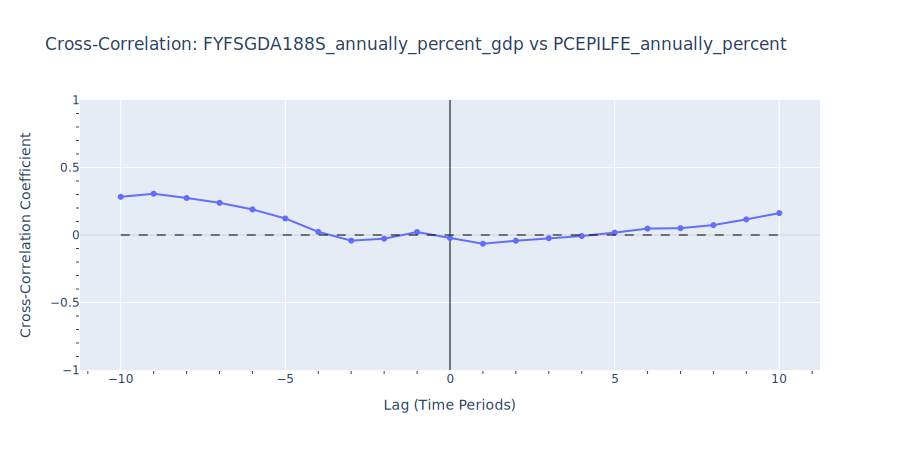

In [11]:
print(f"Calculating cross-correlation for: {deficit_key} and {inflation_key}\n")
lags, ccf_coeffs = calculate_and_plot_cross_correlation(
    metrics_container, 
    deficit_key, 
    inflation_key,
    max_lag=10 
)


⚠️ **Important**

The cross-correlation between the fiscal deficit as a proportion of GDP (`FYFSGDA188S_annually_percent_gdp`) and the annual percentage change in the price index (`PCEPILFE_annually_percent`) shows correlation coefficients which are very low, indicating lack of a significant relationship.

This finding is counterintuitive to the [common expectation](https://miltonfriedman.hoover.org/internal/media/dispatcher/214346/full) that larger deficits might fuel higher inflation. The correlation coefficients observed at negative lags are particularly interesting: a negative lag here means that changes in the fiscal deficit precede changes in inflation, which is what is commonly expected.

Both series exhibit non-constant mean and variance over time, which can sometimes lead to misleading or spurious correlations in time series analysis. However, in this case, even before formally addressing these issues, the observed correlation remains weak and statistically insignificant. This suggests that, at least in the raw data, there is little evidence of a meaningful link between fiscal deficits and subsequent inflation.

Best practices in time series analysis require establishing wide-sense stationarity (WSS) before interpreting cross-correlation results. This typically involves transforming the series, most often by differencing, to achieve constant mean and variance over time. In the next section, I follow this approach to ensure that any observed relationships are not artifacts of non-stationary data, but instead reflect genuine statistical associations.


### Stationarity Testing

We proceed to establish [stationarity](https://en.wikipedia.org/wiki/Stationary_process) before calculating the cross-correlation between `FYFSGDA188S` and `PCEPILFE`. Standard correlation measures assume that the underlying statistical properties (like mean and variance) of the series are stable, to avoid calculating spurious correlations. 
- If the means of the series have a trend, the series will show cross-correlation (as they grow together) but be completly unrelated otherwise. 
- If variance changes, the strength or even direction of correlation might appear different in high-variance periods versus low-variance periods. 

For tis analysis, we aim to obtain wide-sense stationarity (WSS), which means:
- A constant mean.
- A constant variance ([homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity)).
- Autocovariance that depends only on the lag, not on time.

In econometrics, several statistical tests are commonly used to assess the stationarity of stochastic processes:

1. [Augmented Dickey-Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)  
    - **[Null hypothesis](http://en.wikipedia.org/wiki/Null_hypothesis):** A [unit root](https://en.wikipedia.org/wiki/Unit_root_test) is present, indicating a strong cause of non-stationarity.  
    - **Interpretation:** A unit root means shocks to the series are persistent, causing the series to wander without reverting to a mean (not mean-reverting), similarly to a random walk. This also implies that the unconditional variance grows over time, violating stationarity.  
    - **Result:** If the ADF test rejects its null hypothesis (small p-value), it suggests the series is mean-reverting and addresses one major source of non-constant mean and variance.

2. [Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test](https://en.wikipedia.org/wiki/KPSS_test)  
    - **Null hypothesis:** The series is stationary around a deterministic trend (i.e., [trend-stationarity](https://en.wikipedia.org/wiki/Trend-stationary_process)), either around a constant (regression='c') or a trend (regression='ct').  
    - **Interpretation:** The series is mean-reverting and, after shocks, returns to the trend (which may be constant or a function of time).  
    - **Result:** If the KPSS test rejects its null hypothesis (small p-value), it indicates the series is not stationary. If you have already addressed mean issues (e.g., by differencing and confirming with the ADF test), then a KPSS rejection often points to heteroscedasticity or other forms of non-stationarity in variance or autocovariance. Conversely, failing to reject the KPSS null hypothesis (large p-value) provides evidence in favor of stationarity, including homoscedasticity.


If the series do not pass the ADF test, the typical approach is **differencing**. Differencing involves creating a new series from the differences between consecutive observations (effectively a discrete time derivative). This method can help stabilize the mean of a time series by removing changes in its level, thereby eliminating trends. Cross-correlating these differenced series means examining how the changes in one series relate to changes in the other. This is different from cross-correlating the original (level) series, which indicates how the absolute values of one series relate to those of the other at different lags.

However, an interesting behavior to examine is whether a shock (peak) in the level series also results in a shock in the other, possibly with a lag. Differencing a peak generates a double-peaked signal, with an increasing and a decreasing component in sequence, which will still be observable in the cross-correlation of the differenced series.

For completeness, we should first apply the ADF test, difference if needed, and retest. When the ADF test indicates no unit root, we should apply the KPSS test to look for heteroscedasticity (non-constant variance). If the KPSS test rejects the null hypothesis (trend-stationarity), that's most likely due to heteroscedasticity. To remove heteroscedasciticy one approach is to take the logarythm of the series, before differencing, in order to stabilize the variance. 

#### ADF Test

Let's check if the series have a unit root. 

In [12]:
def adf_report(series: pd.Series, name: str) -> None:
    """
    Perform Augmented Dickey-Fuller test and print the results.
    H0: a unit root is present in the time series data.

    :param series: The time series data to test.
    :param name: The name of the series for reporting.
    :returns: None
    """

    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  #Lags Used: {result[2]}")
    print(f"  #Observations: {result[3]}")
    for key, value in result[4].items():
        print(f"    Critical Value ({key}): {value:.4f}")
    print("-" * 40)

In [13]:
adf_report(metrics_container[deficit_key].data["value"], deficit_key)
adf_report(metrics_container[inflation_key].data["value"], inflation_key)

ADF Test for FYFSGDA188S_annually_percent_gdp:
  Test Statistic: -3.3105
  p-value: 0.0144
  #Lags Used: 1
  #Observations: 63
    Critical Value (1%): -3.5387
    Critical Value (5%): -2.9086
    Critical Value (10%): -2.5919
----------------------------------------
ADF Test for PCEPILFE_annually_percent:
  Test Statistic: -1.6917
  p-value: 0.4354
  #Lags Used: 5
  #Observations: 59
    Critical Value (1%): -3.5464
    Critical Value (5%): -2.9119
    Critical Value (10%): -2.5937
----------------------------------------


The low p-value of the ADF test for `FYFSGDA188S_annually_percent_gdp` indicates that it is highly unlikely that the series has a unit root. In contrast, the higher p-value for `PCEPILFE_annually_percent` does not rule out the presence of a unit root.

To address this, we can difference the series to remove potential unit roots. However, it is important to note that this changes the interpretation of the cross-correlation calculation. The question that we set out to answer now becomes:

**"Does the rate of change of the fiscal deficit correlate with the rate of change of price inflation?"**

#### Differencing and Re-Testing

In [14]:
# Calculate difference (diff) between consecutive elements of the series 
# and add the new series back to metrics_container with updated units and keys

def calc_diff(df: pd.DataFrame, value_col: str) -> pd.DataFrame:
    """
    Calculate the difference between consecutive elements.

    :param df: DataFrame with 'timestamp' and 'value_col' columns.
    :param value_col: Name of the column containing the values to calculate difference on.
    :returns: a DataFrame with 'timestamp' and 'diff' columns.
    """
    df = df.copy().sort_values("timestamp")
    df["diff"] = df[value_col].diff()
    return df.dropna(subset=["diff"])

def add_diff_metric(
    metrics_container: dict, 
    src_key: str, 
    new_key: str, 
    units: str, 
    description_suffix: str
) -> None:
    """
    Add a difference metric to the metrics_container.

    :param metrics_container: Dictionary containing FredMetric instances.
    :param src_key: Key of the source metric in metrics_container.
    :param new_key: Key for the new metric to be added.
    :param units: Units for the new metric.
    :param description_suffix: Suffix to append to the description of the new metric.
    :returns: None
    """

    src_metric = metrics_container[src_key]
    df = src_metric.data
    diff_df = calc_diff(df, "value")
    diff_df["name"] = src_metric.name
    diff_df["units"] = units
    diff_df = diff_df[["timestamp", "name", "diff", "units"]].rename(columns={"diff": "value"})
    metrics_container[new_key] = FredMetric(
        name=src_metric.name,
        description=src_metric.description + description_suffix,
        units=units,
        frequency="annually",
        data=diff_df
    )
    print(f"Added {new_key} to metrics_container. Shape: {diff_df.shape}")

In [15]:
params = [
    dict(
        src_key=deficit_key,
        new_key="diff_" + deficit_key,
        units="percent",
        description_suffix=" (Difference between consecutive values)"
),
    dict(
        src_key=inflation_key,
        new_key="diff_" + inflation_key,
        units="percent",
        description_suffix=" (Difference between consecutive values)"
    ),
]

for param in params:
    add_diff_metric(metrics_container, **param)

Added diff_FYFSGDA188S_annually_percent_gdp to metrics_container. Shape: (64, 4)
Added diff_PCEPILFE_annually_percent to metrics_container. Shape: (64, 4)


In [16]:
diff_deficit_key = "diff_FYFSGDA188S_annually_percent_gdp"
diff_inflation_key = "diff_PCEPILFE_annually_percent"

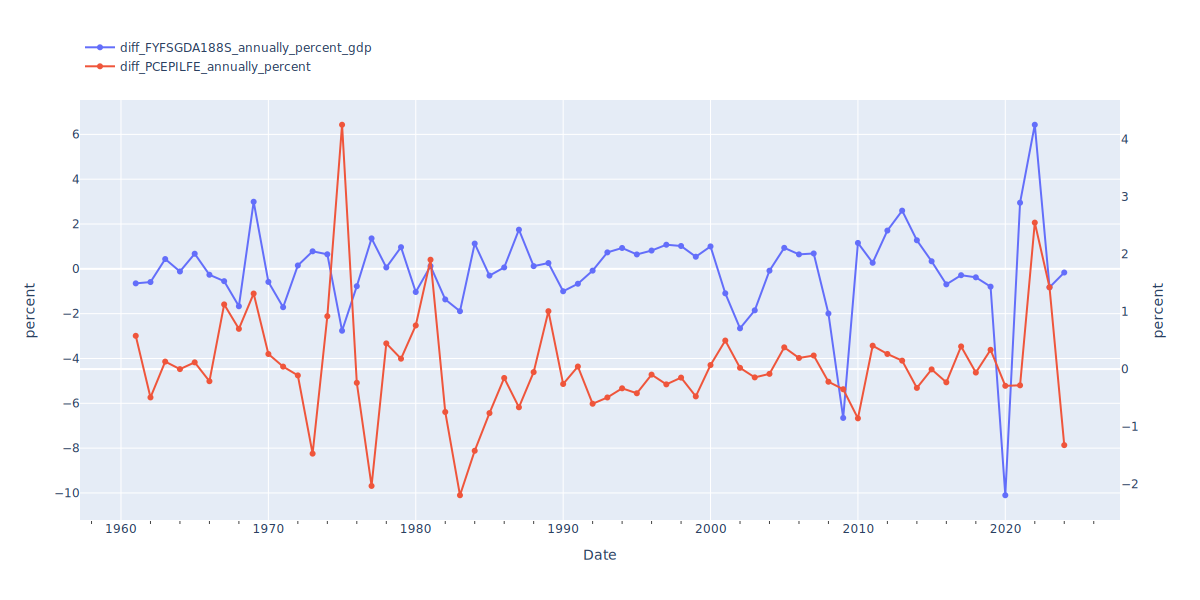

In [17]:
plot_dual_axis_series(
    metrics_container,
    y1_keys=[diff_deficit_key],
    y2_keys=[diff_inflation_key]
)

The plots show two series that don't seem to show a trend but there might be some heteroscedasticity, which the ADF test won't detect, but the KPSS test will. 

In [18]:
# Run ADF test on the differenced series
adf_report(metrics_container[diff_deficit_key].data["value"], diff_deficit_key)
adf_report(metrics_container[diff_inflation_key].data["value"], diff_inflation_key)

ADF Test for diff_FYFSGDA188S_annually_percent_gdp:
  Test Statistic: -7.2650
  p-value: 0.0000
  #Lags Used: 1
  #Observations: 62
    Critical Value (1%): -3.5405
    Critical Value (5%): -2.9094
    Critical Value (10%): -2.5923
----------------------------------------
ADF Test for diff_PCEPILFE_annually_percent:
  Test Statistic: -3.3138
  p-value: 0.0143
  #Lags Used: 4
  #Observations: 59
    Critical Value (1%): -3.5464
    Critical Value (5%): -2.9119
    Critical Value (10%): -2.5937
----------------------------------------


The ADF test this time returned very convincing p-values, strongly suggesting that both series do not have a unit root. This means the series are likely stationary in mean, and shocks to the series are not persistent over time.

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Trend-Stationarity Test

Let's check for trend-stationarity using the KPSS test. Given the visible heteroscedasticity in the differenced series, we expect the test to reject the null hypothesis of trend-stationarity. This would confirm that, while differencing removed the unit root (as shown by the ADF test), the variance is still not constant over time.

In [19]:
def kpps_report(series: pd.Series, name: str, regression: str = "c") -> None:
    """
    Perform KPSS test and print a report.
    H0: the process is trend-stationary.

    :param series: The data to test.
    :param name: The name of the series for reporting.
    :param regression: The type of regression to use in the test. "c" for constant, "ct" for trend.
    :returns: None
    """
   
    kpss_stat, p_value, lags, crit_values = kpss(series, regression=regression, nlags="auto")
    
    print(f"KPSS Test for {name} (regression='{regression}'):")
    print(f"  KPSS Statistic: {kpss_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  #Lags Used: {lags}")
    print("  Critical Values:")
    for key, value in crit_values.items():
        print(f"    {key}: {value:.4f}")
   
    print("-" * 40)

In [20]:
kpps_report(metrics_container[diff_deficit_key].data["value"], diff_deficit_key)
kpps_report(metrics_container[diff_inflation_key].data["value"], diff_inflation_key)

KPSS Test for diff_FYFSGDA188S_annually_percent_gdp (regression='c'):
  KPSS Statistic: 0.0666
  p-value: 0.1000
  #Lags Used: 7
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
----------------------------------------
KPSS Test for diff_PCEPILFE_annually_percent (regression='c'):
  KPSS Statistic: 0.1544
  p-value: 0.1000
  #Lags Used: 5
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
----------------------------------------


/var/folders/lk/21hq1pz55xn204vhrhz_npp40000gn/T/ipykernel_19399/2369050582.py:12: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/lk/21hq1pz55xn204vhrhz_npp40000gn/T/ipykernel_19399/2369050582.py:12: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




As expected, the KPSS test indicates that the differenced series are not stationary. Financial time series often show periods of higher volatility followed by lower volatility (which can be modelled using [ARCH/GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity)). 

Nevertheless, it is meaningful to examine the cross-correlation of these two series, after removing their unit roots. 

### Cross-Correlation of Differenced Series

Calculating cross-correlation for: diff_FYFSGDA188S_annually_percent_gdp and diff_PCEPILFE_annually_percent

Cross-correlation between diff_FYFSGDA188S_annually_percent_gdp and diff_PCEPILFE_annually_percent:
Method: Variable segment length (full overlap). Max lag considered: 10.
Original number of data points (N): 64.
Negative lags indicate diff_FYFSGDA188S_annually_percent_gdp leads diff_PCEPILFE_annually_percent.
  Lag: -10, CCF: 0.0185, Points used: 54
  Lag: -9, CCF: 0.1427, Points used: 55
  Lag: -8, CCF: -0.0100, Points used: 56
  Lag: -7, CCF: 0.0025, Points used: 57
  Lag: -6, CCF: 0.0688, Points used: 58
  Lag: -5, CCF: 0.0186, Points used: 59
  Lag: -4, CCF: -0.0087, Points used: 60
  Lag: -3, CCF: -0.2224, Points used: 61
  Lag: -2, CCF: -0.1029, Points used: 62
  Lag: -1, CCF: 0.2776, Points used: 63
  Lag:  1, CCF: -0.1843, Points used: 63
  Lag:  2, CCF: -0.0327, Points used: 62
  Lag:  3, CCF: -0.0506, Points used: 61
  Lag:  4, CCF: -0.0229, Points used: 60
  Lag:  5, 

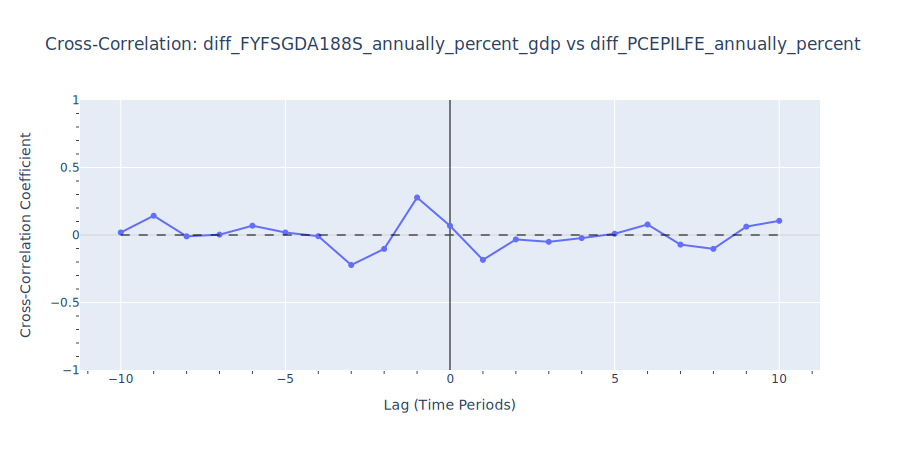

In [21]:
print(f"Calculating cross-correlation for: {diff_deficit_key} and {diff_inflation_key}\n")
lags, ccf_coeffs = calculate_and_plot_cross_correlation(
    metrics_container, 
    diff_deficit_key, 
    diff_inflation_key,
    max_lag=10 
)

The resulting cross-correlation, more meaningful for negative lags, is minimal and noisy, again strongly indicating weak to no relationship between the two series for any lag. 

After this analysis, I am quite convinced that the data in our possession does not show evidence of cross-correlation. Removing heteroscedasticity is possible with additional manipulation of the series, but given the consistent and very low value of the cross-correlation both before and after the removal of the unit roots, it is highly unlikely to change the results. 

## Conclusions

This analysis addresses a question at the heart of a contentious debate, especially in light of recent surges in fiscal deficits. I promised not to consult other research or opinions before conducting my own analysis, and I kept that promise, up until this very paragraph. At this point, I cast an eye over some of the literature and was immediately overwhelmed by a mountain of search results. Most sources (see the list below) that examine historical data reach the same conclusion I did: there is little to no correlation, and this holds true across most developed economies. Yet, many go on to rationalize this finding with appeals to "economic theory," offering a patchwork of statistically unsubstantiated and logically tenuous explanations, often dressed up with self-referential mathematics that does more to obscure than to clarify the lack of robust data or genuine understanding. So much ado about nothing. It appears that the term "economic theory" often serves as a catch-all for the prevailing dogma, what most credentialed economists learned in school and what conveniently preserves both their professional standing and the status quo.

Notably, I could not find a source that, as I did, simply presents the data and refrains from speculative theorizing about the reasons for the lack of the "expected" correlation. It is abundantly clear that when data is scarce and the number of parameters to fit is high, the first step should be to acknowledge these limitations. Rather than constructing elaborate theoretical frameworks to force a conclusion, it is wiser to focus on maintaining intellectual humility, removing unsubstantiated constraints, and letting ambitious experimentation explore and collect empirical evidence.  
Macroeconomics, unlike the hard sciences, cannot run controlled experiments on parallel universes; we lack the luxury of hundreds of identical economies to tinker with. In fields like experimental physics, chemistry, or biology, mathematical models are powerful because they are testable and falsifiable with plenty of data (this is the core of the scientific method). It seems to me that in macroeconomics, they too often become elaborate rituals, comforting, but ultimately unmoored from empirical reality.

The [FRED](https://fred.stlouisfed.org/) datasets provide extensive opportunities to explore relationships between fiscal and monetary policies and key economic indicators, such as unemployment rates and price or wage inflation. These might be the subject of future investigations. It would also be interesting to re-produce a similar analysis for other fiat currency governments, such as China, Japan, UK, Canada, etc.

Below are a few readings I consulted. All of them note a lack of correlation for "advanced economies and low-inflation country groups" (such as the USA), which, as the IMF paper by Luis Catao and Marco E. Terrones puts it, "begs the question why the theory seems to be violated." In my view, if a theory is contradicted by data, it is simply a wrong theory.

- [Deficits and Inflation, by Milton Friedman (1981)](https://miltonfriedman.hoover.org/internal/media/dispatcher/214251/full): a notorious example of the unsubstantiated "economic theory" doctrine I referred to above, which has since become the core of what's taught in schools and universities. See also [Quantity Theory of Money (QTM), a.k.a Monetarism](https://miltonfriedman.hoover.org/internal/media/dispatcher/214346/full).
- [Some Unpleasant Monetarist Arithmetic, by Thomas J. Sargent and Neil Wallace (1981)](https://www.minneapolisfed.org/research/quarterly-review/some-unpleasant-monetarist-arithmetic): the quintessential "castle in the sky".
- [Fiscal Deficits and Inflation, by Luis Catao and Marco E. Terrones (2003)](https://www.imf.org/external/pubs/ft/wp/2003/wp0365.pdf): the "Conclusions" section is where I got the quote above.
- [Do Budget Deficits Cause Inflation?, by Keith Sill (2005)](https://www.philadelphiafed.org/-/media/FRBP/Assets/Economy/Articles/business-review/2005/q3/Q3_05_Sill.pdf?sc_lang=en): the author notes the lack of correlation for many countries ("the U.S. and, for that matter, in most of the world’s advanced economies") and tries to explain it with the independence of monetary and fiscal policy, with arguments that seem unaware of the fact that the US government is the monopoly issuer of a [fiat currency](https://en.wikipedia.org/wiki/Fiat_money).
- [The Inflationary Risks of Rising Federal Deficits and Debt, by The Budget Lab (2025)](https://budgetlab.yale.edu/research/inflationary-risks-rising-federal-deficits-and-debt): a recent example of an analysis that uses virtually no data and builds mathematical models and simulations that are as solid as a house of straw.

## Supplemental 

### Further Attempt at Generating Stationary Series

We can try to apply the logarithm to the `PCEPILFE_annually_percent` series, and then difference it, 

In [22]:
# Create a new series: log(PCEPILFE_annually_percent)

# Get the original series
df_pcepilfe = metrics_container[inflation_key].data.copy()

# To avoid log(0) or log of negative values, filter out non-positive values
mask_positive = df_pcepilfe["value"] > 0
log_values = np.full_like(df_pcepilfe["value"], np.nan, dtype=np.float64)
log_values[mask_positive] = np.log(df_pcepilfe.loc[mask_positive, "value"])

# Create a new DataFrame for the log series
df_log = df_pcepilfe.copy()
df_log["value"] = log_values
df_log = df_log.dropna(subset=["value"])  # Drop rows where log is not defined

df_log["name"] = "log_PCEPILFE"
df_log["units"] = "percent_log"

# Add to metrics_container
metrics_container["log_" + inflation_key] = FredMetric(
    name="log_PCEPILFE",
    description="Natural logarithm of {inflation_key} (filtered for positive values)",
    units="percent_log",
    frequency="annually",
    data=df_log
)

print(f"Created log_{inflation_key}. Shape: {df_log.shape}")

Created log_PCEPILFE_annually_percent. Shape: (65, 4)


In [23]:
log_inflation_key = "log_PCEPILFE_annually_percent"

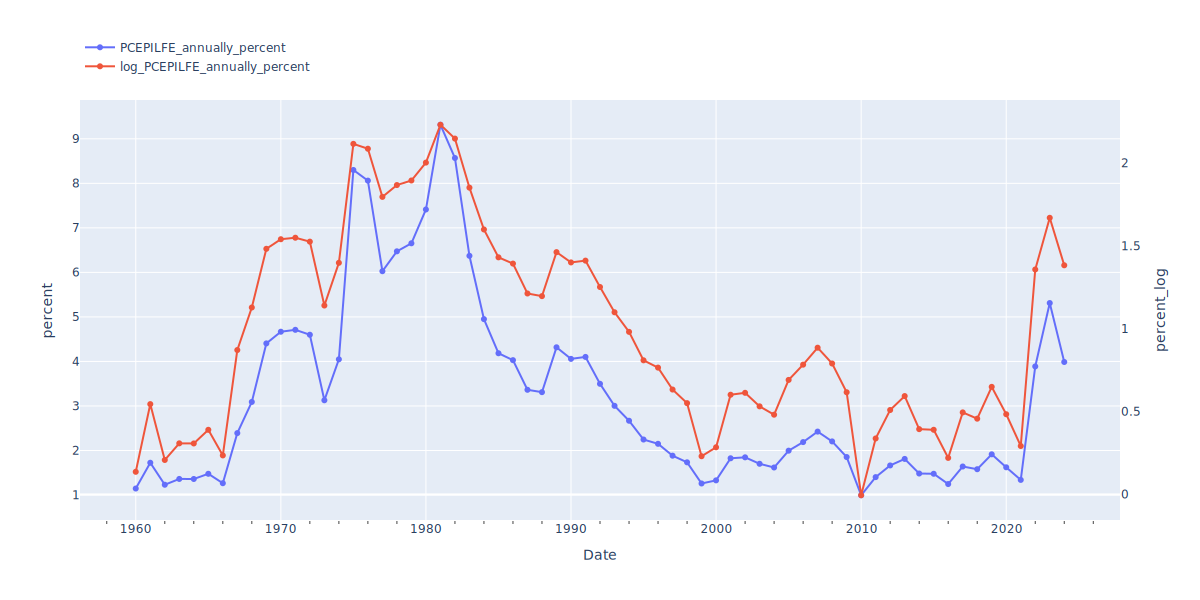

In [24]:
plot_dual_axis_series(
    metrics_container,
    y1_keys=[inflation_key],
    y2_keys=[log_inflation_key]
)

The two series are very similar, this is because the 
Unit root and stationary tests.

In [25]:
adf_report(metrics_container[log_inflation_key].data["value"], log_inflation_key)
kpps_report(metrics_container[log_inflation_key].data["value"], log_inflation_key)

ADF Test for log_PCEPILFE_annually_percent:
  Test Statistic: -1.8947
  p-value: 0.3345
  #Lags Used: 2
  #Observations: 62
    Critical Value (1%): -3.5405
    Critical Value (5%): -2.9094
    Critical Value (10%): -2.5923
----------------------------------------
KPSS Test for log_PCEPILFE_annually_percent (regression='c'):
  KPSS Statistic: 0.3807
  p-value: 0.0855
  #Lags Used: 4
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
----------------------------------------


Differencing the log-transformed series.

In [26]:
params = dict(
        src_key=log_inflation_key,
        new_key="diff_" + log_inflation_key,
        units="percent_log",
        description_suffix=" (Difference between consecutive values)"
    )

add_diff_metric(metrics_container, **params)

Added diff_log_PCEPILFE_annually_percent to metrics_container. Shape: (64, 4)


In [27]:
diff_log_inflation_key = "diff_log_PCEPILFE_annually_percent"

In [28]:
adf_report(metrics_container[diff_log_inflation_key].data["value"], diff_log_inflation_key)
kpps_report(metrics_container[diff_log_inflation_key].data["value"], diff_log_inflation_key)

ADF Test for diff_log_PCEPILFE_annually_percent:
  Test Statistic: -6.3787
  p-value: 0.0000
  #Lags Used: 1
  #Observations: 62
    Critical Value (1%): -3.5405
    Critical Value (5%): -2.9094
    Critical Value (10%): -2.5923
----------------------------------------
KPSS Test for diff_log_PCEPILFE_annually_percent (regression='c'):
  KPSS Statistic: 0.1806
  p-value: 0.1000
  #Lags Used: 4
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
----------------------------------------


/var/folders/lk/21hq1pz55xn204vhrhz_npp40000gn/T/ipykernel_19399/2369050582.py:12: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




As suspected, applying a logarithmic transformation does not alter the outcome of the stationarity tests for the `PCEPILFE` series likely due to persistent heteroscedasticity.